# Part 3: Train with small dataset

## Lib & Dependencies

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import BertModel
from transformers import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

import time
from tqdm import tqdm

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import Data

In [12]:
df = pd.read_csv('data/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [13]:
positive_samples = df[df['sentiment'] == 'positive']
negative_samples = df[df['sentiment'] == 'negative']

# Randomly sample 500 from each
positive_subset = positive_samples.sample(n=500, random_state=42)
negative_subset = negative_samples.sample(n=500, random_state=42)

subset_df = pd.concat([positive_subset, negative_subset])
df = subset_df.sample(frac=1, random_state=42).reset_index(drop=True)

## Data Cleaning

In [18]:
df.duplicated().sum()

0

In [19]:
df.drop_duplicates(inplace=True)

## Preprocessing

In [21]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

## Model

In [23]:
class IMDbDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_len):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        sentiment = self.sentiments.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

D:\Conda\envs\sc4001env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
MAX_LEN = 256
BATCH_SIZE = 32

train_dataset = IMDbDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = IMDbDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [25]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Conda\envs\sc4001env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=sentiments)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == sentiments)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=sentiments)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == sentiments)
            total_loss += loss.item()

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

In [32]:
EPOCHS = 3

times = []
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    start_time = time.time()
    
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss {train_loss}, accuracy {train_acc}')
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    test_acc, test_loss = evaluate_model(model, test_loader, device)
    print(f'Test loss {test_loss}, accuracy {test_acc}')
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    
    time_taken = time.time()-start_time
    print(f'time taken: {time_taken}')
    times.append(time_taken)

Epoch 1/3


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.12s/it]


Train loss 0.6698366212844848, accuracy 0.5975
Test loss 0.5814639755657741, accuracy 0.84
time taken: 33.52062201499939
Epoch 2/3


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.12s/it]


Train loss 0.4227880084514618, accuracy 0.84375
Test loss 0.27007474111659185, accuracy 0.895
time taken: 33.56447649002075
Epoch 3/3


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.13s/it]


Train loss 0.22275915533304214, accuracy 0.92
Test loss 0.25629303018961636, accuracy 0.905
time taken: 33.551353931427


In [51]:
# Evaluate the model on test set
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(sentiments.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.90      0.91      0.91       100
    positive       0.91      0.90      0.90       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



In [52]:
model.save_pretrained("./saved_model/model_distilbertC3/")

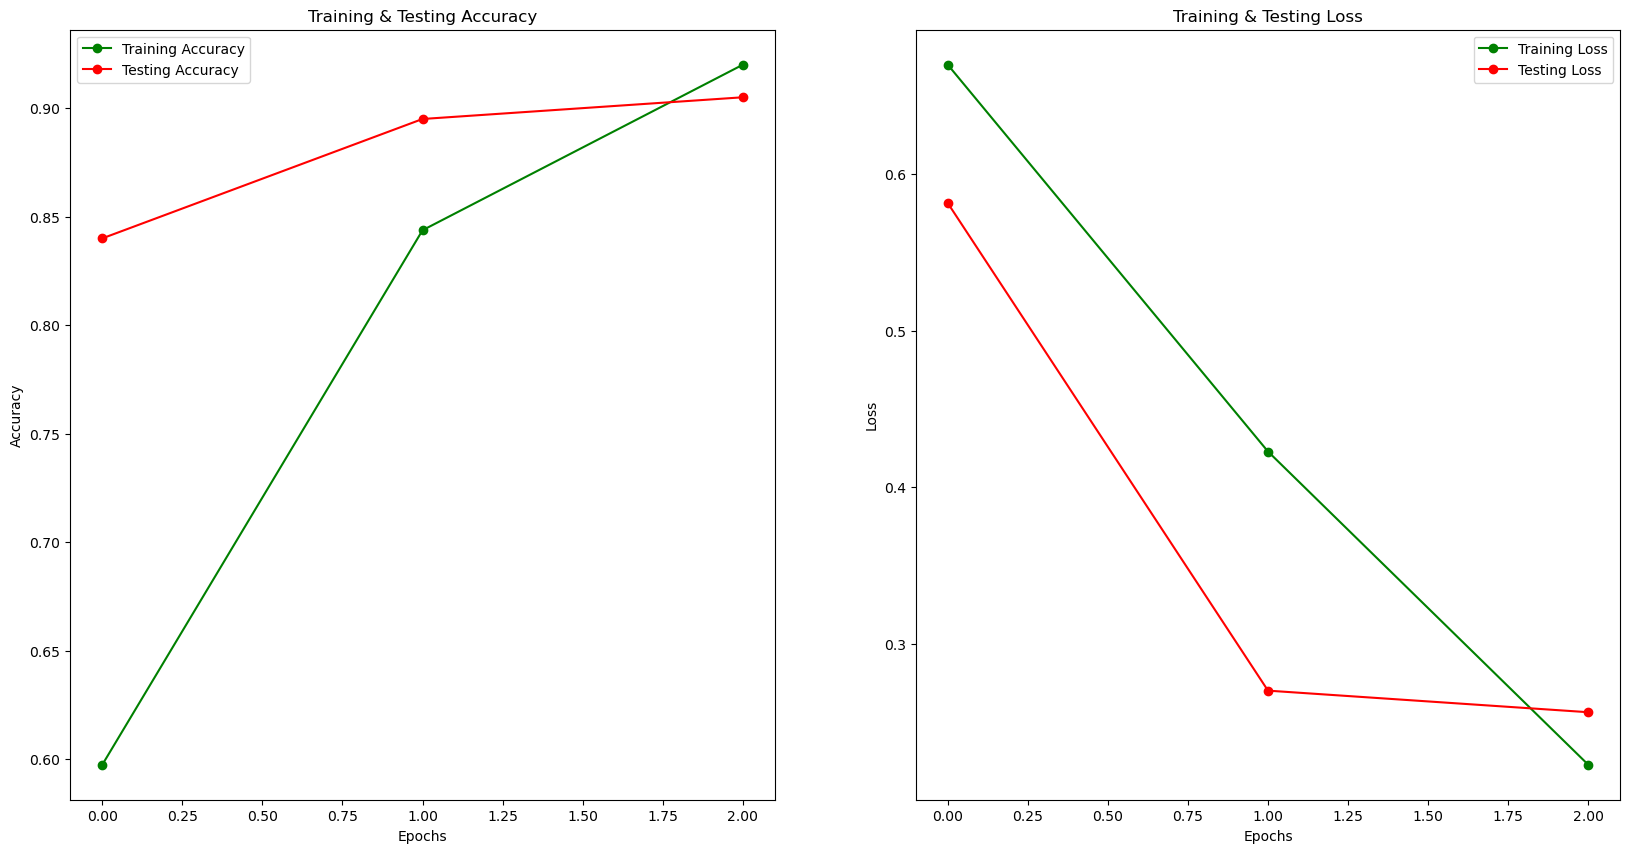

In [53]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

train_accs_list = []
for tensor in train_accs:
    train_accs_list.append(tensor.cpu().numpy().item())

test_accs_list = []
for tensor in test_accs:
    test_accs_list.append(tensor.cpu().numpy().item())

ax[0].plot(epochs , train_accs_list , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , test_accs_list , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , test_losses , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [54]:
print(f'train_accs: {train_accs_list}')
print(f'test_accs: {test_accs_list}')
print(f'train_losses: {train_losses}')
print(f'test_losses: {test_losses}')

train_accs: [0.5975, 0.84375, 0.92]
test_accs: [0.84, 0.895, 0.905]
train_losses: [0.6698366212844848, 0.4227880084514618, 0.22275915533304214]
test_losses: [0.5814639755657741, 0.27007474111659185, 0.25629303018961636]


Text(95.72222222222221, 0.5, 'Actual')

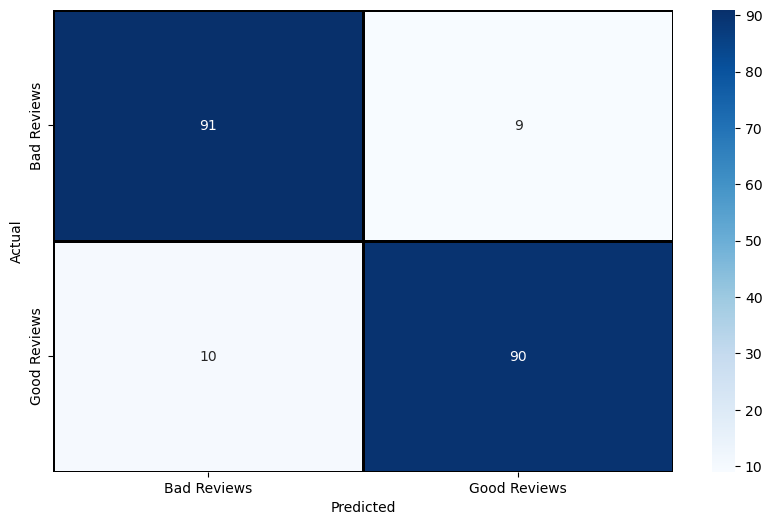

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize = (10,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")